In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.metrics import roc_auc_score

In [6]:
import lightgbm as lgb
import xgboost as xgb

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data gathering

In [ ]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')

In [3]:
features=[c for c in train.columns if c not in ['ID_code', 'target']]

In [4]:
y=train['target']
X= train.drop(['target', 'ID_code'], axis=1)

In [5]:
ID_code=test['ID_code']
X_test = test.drop(['ID_code'],axis = 1)

In [49]:
sc = StandardScaler()
X= sc.fit_transform(X)
X_test = sc.transform(X_test)
n_splits = 5 # Number of K-fold Splits

splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True).split(X, y))

### LightGBM

In [18]:
lgb_param = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : 1111,
    "verbosity" : 1,
    "seed": 1111
}

In [9]:
xgb_param = {
    'booster':"gbtree",
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'max_depth': 2,
    'subsample':0.5,
    #'max_delta_step': 1.8,
    'colsample_bytree': 0.1,
    'eta': 0.02,
    #'gamma': 0.65,
    'eval_metric':'auc',
    'scale_pos_weight': 0.1004
        }

In [14]:
n_splits = 5 # Number of K-fold Splits
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True,random_state=1111).split(X, y))

In [15]:
lgb_oof = np.zeros(len(X))
#xgb_oof = np.zeros(len(X))
#et_oof = np.zeros(len(X))
#rf_oof= np.zeros(len(X))

blend=np.zeros((X.shape[0], 4))
predictions=np.zeros((X_test.shape[0], 25))

In [21]:
for i, (train_idx, valid_idx) in enumerate(splits):  
    print(f'Fold {i + 1}')
    # Data shuffling
    X = np.array(X)
    y = np.array(y)
    x_train = X[train_idx.astype(int)]
    y_train = y[train_idx.astype(int)]
    
    for t in range(5):
        print ('i: ', i, 't: ', t)
        X_t, y_t = shuffle(x_train, y_train)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
        X_t=np.array(X_t)
        y_t=np.array(y_t)
    
    # LightGBM
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X[valid_idx.astype(int)], label=y[valid_idx.astype(int)])
        watchlist = [(trn_data, 'train'), (val_data, 'valid')]
        lgb_clf=lgb.train(lgb_param, trn_data, 500000, valid_sets = [trn_data, val_data], early_stopping_rounds=3000, verbose_eval=1000)
    
        #blend[valid_idx, 0] = lgb_clf.predict(X[valid_idx], num_iteration=lgb_clf.best_iteration)
        lgb_oof[valid_idx] += lgb_clf.predict(X[valid_idx], num_iteration=lgb_clf.best_iteration)/5
    
        predictions[:,i*5+t] = lgb_clf.predict(X_test, num_iteration=lgb_clf.best_iteration) 
    
    #XGboost
    #trn_data = xgb.DMatrix(X_t, label=y_t)
    #val_data = xgb.DMatrix(X[valid_idx.astype(int)], label=y[valid_idx.astype(int)])
    #watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    #xgb_clf=xgb.train(xgb_param, trn_data, 100000, evals=watchlist, early_stopping_rounds=2500,verbose_eval=1000)
    
    #xgb_valid=xgb.DMatrix(X[valid_idx])
    #blend[valid_idx, 1] = xgb_clf.predict(xgb_valid, ntree_limit=xgb_clf.best_ntree_limit)
    #xgb_oof[valid_idx]=blend[valid_idx, 1]
    
    #xgb_test=xgb.DMatrix(np.array(X_test))
    #predictions[:,1] += xgb_clf.predict(xgb_test, ntree_limit=xgb_clf.best_ntree_limit) / n_splits
    
    #Extratree
    #et_clf=ExtraTreesClassifier(n_estimators=1200,criterion= 'gini',min_samples_split=300,min_samples_leaf=9,max_features=3, n_jobs=-1)
    #et_clf.fit(X_t, y_t)
    
    #blend[valid_idx, 2]=et_clf.predict_proba(X[valid_idx])[:,1]
    #et_oof[valid_idx]=blend[valid_idx, 2]
    
    #predictions[:,2] += et_clf.predict_proba(X_test)[:,1]/ n_splits
    
    # Random forest
    #rf_clf=RandomForestClassifier(class_weight='balanced',criterion='entropy',max_depth=19,max_features=1,min_samples_leaf=110,
     #                            min_samples_split=230,n_estimators=1600,n_jobs=-1)
    #rf_clf.fit(X_t,y_t)
    
    #blend[valid_idx,3]=rf_clf.predict_proba(X[valid_idx])[:,1]
    #rf_oof[valid_idx]=blend[valid_idx,3]
    
    #predictions[:,3] += rf_clf.predict_proba(X_test)[:,1]/ n_splits
    
    #xgb_valid=xgb.DMatrix(x_train[valid_idx])
    #oof[valid_idx] = clf.predict(xgb_valid, ntree_limit=clf.best_ntree_limit)
    
    #oof[valid_idx] = lgb_clf.predict(X[valid_idx], num_iteration=lgb_clf.best_iteration)
    
    
    #predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / n_splits
#blend_clf = LogisticRegression()
#blend_clf.fit(blend, np.array(y).ravel())
#y_pred = blend_clf.predict_proba(blend)[:,1]
#submission=blend_clf.predict_proba(predictions)[:,1]

print("lgb score: {:<8.5f}".format(roc_auc_score(y, lgb_oof)))
#print("xgb score: {:<8.5f}".format(roc_auc_score(y, xgb_oof)))
#print("et score: {:<8.5f}".format(roc_auc_score(y, et_oof))) 
#print("rf score: {:<8.5f}".format(roc_auc_score(y, rf_oof))) 
#print("CV score: {:<8.5f}".format(roc_auc_score(y, y_pred)))

Fold 1
i:  0 t:  0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.893128	valid_1's auc: 0.875202
[2000]	training's auc: 0.901819	valid_1's auc: 0.883277
[3000]	training's auc: 0.908263	valid_1's auc: 0.888356
[4000]	training's auc: 0.913065	valid_1's auc: 0.891709
[5000]	training's auc: 0.916693	valid_1's auc: 0.893802
[6000]	training's auc: 0.919637	valid_1's auc: 0.895211
[7000]	training's auc: 0.922252	valid_1's auc: 0.896041
[8000]	training's auc: 0.924636	valid_1's auc: 0.896585
[9000]	training's auc: 0.926936	valid_1's auc: 0.896901
[10000]	training's auc: 0.929098	valid_1's auc: 0.897085
[11000]	training's auc: 0.931208	valid_1's auc: 0.897145
[12000]	training's auc: 0.93327	valid_1's auc: 0.897148
[13000]	training's auc: 0.935323	valid_1's auc: 0.897159
[14000]	training's auc: 0.937313	valid_1's auc: 0.897016
[15000]	training's auc: 0.939235	valid_1's auc: 0.897004
Early stopping, best iteration is:
[12522]	training's auc: 0.934352	vali

[11000]	training's auc: 0.930924	valid_1's auc: 0.898411
[12000]	training's auc: 0.932975	valid_1's auc: 0.898348
[13000]	training's auc: 0.934965	valid_1's auc: 0.898252
[14000]	training's auc: 0.936957	valid_1's auc: 0.898132
Early stopping, best iteration is:
[11386]	training's auc: 0.931715	valid_1's auc: 0.898432
i:  1 t:  4
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.892967	valid_1's auc: 0.879665
[2000]	training's auc: 0.901696	valid_1's auc: 0.886374
[3000]	training's auc: 0.908472	valid_1's auc: 0.891332
[4000]	training's auc: 0.913291	valid_1's auc: 0.894277
[5000]	training's auc: 0.917025	valid_1's auc: 0.896211
[6000]	training's auc: 0.920035	valid_1's auc: 0.897121
[7000]	training's auc: 0.922659	valid_1's auc: 0.897487
[8000]	training's auc: 0.925013	valid_1's auc: 0.897806
[9000]	training's auc: 0.927253	valid_1's auc: 0.898106
[10000]	training's auc: 0.929414	valid_1's auc: 0.898135
[11000]	training's auc: 0.931514	valid_1's 

[7000]	training's auc: 0.921695	valid_1's auc: 0.901501
[8000]	training's auc: 0.924109	valid_1's auc: 0.901795
[9000]	training's auc: 0.926396	valid_1's auc: 0.901993
[10000]	training's auc: 0.92854	valid_1's auc: 0.902072
[11000]	training's auc: 0.930654	valid_1's auc: 0.902112
[12000]	training's auc: 0.932713	valid_1's auc: 0.9022
[13000]	training's auc: 0.934721	valid_1's auc: 0.902123
[14000]	training's auc: 0.936705	valid_1's auc: 0.902076
Early stopping, best iteration is:
[11870]	training's auc: 0.932452	valid_1's auc: 0.902216
i:  3 t:  3
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.891984	valid_1's auc: 0.883404
[2000]	training's auc: 0.900924	valid_1's auc: 0.890276
[3000]	training's auc: 0.907724	valid_1's auc: 0.89533
[4000]	training's auc: 0.912611	valid_1's auc: 0.898301
[5000]	training's auc: 0.91635	valid_1's auc: 0.90024
[6000]	training's auc: 0.919341	valid_1's auc: 0.901225
[7000]	training's auc: 0.921968	valid_1's auc: 0.

In [46]:
print("lgb score: {:<8.5f}".format(roc_auc_score(y, lgb_oof)))
print("xgb score: {:<8.5f}".format(roc_auc_score(y, xgb_oof)))
print("et score: {:<8.5f}".format(roc_auc_score(y, et_oof))) 
print("rf score: {:<8.5f}".format(roc_auc_score(y, rf_oof))) 

lgb score: 0.90069 
xgb score: 0.90026 
et score: 0.88918 
rf score: 0.89130 


In [105]:
skf= list(StratifiedKFold(n_splits=3, shuffle=True,random_state=1111).split(train_lr, y))

In [106]:
blend_oof=np.zeros(len(y))
for i, (train_idx, valid_idx) in enumerate(skf):
    print (i)
    X=np.array(blend_train)
    y=np.array(y)
    x_train = X[train_idx.astype(int)]
    y_train = y[train_idx.astype(int)]
    x_valid = X[valid_idx.astype(int)]
    
    blend_clf = LogisticRegression(C=0.1)
    blend_clf.fit(x_train, y_train)
    blend_oof[valid_idx]=blend_clf.predict_proba(x_valid)[:,1]
    #y_pred = blend_clf.predict_proba(blend)[:,1]
    #submission=blend_clf.predict_proba(predictions)[:,1]
print("CV score: {:<8.5f}".format(roc_auc_score(y, blend_oof)))

0
1
2
CV score: 0.11336 


In [41]:
blend_train= pd.DataFrame(blend)

In [98]:
blend_train['lgb_rank']=blend_train[0].rank(ascending=True)
blend_train['xgb_rank']=blend_train[1].rank(ascending=True)
blend_train['et_rank']=blend_train[2].rank(ascending=True)
blend_train['rf_rank']=blend_train[3].rank(ascending=True)

In [100]:
blend_train['lgb_pred']=blend_train['lgb_rank']/200000
blend_train['xgb_pred']=blend_train['xgb_rank']/200000
blend_train['et_pred']=blend_train['et_rank']/200000
blend_train['rf_pred']=blend_train['rf_rank']/200000

In [97]:
print("CV score: {:<8.5f}".format(roc_auc_score(y, blend_train['et_pred'])))

CV score: 0.88918 


In [25]:
#blend_train=pd.read_csv("data/oof_train.csv")
blend_train.describe()

lgb            xgb             et             rf  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.124640       0.031736       0.141378       0.462142   
std         0.187732       0.095804       0.014480       0.029265   
min         0.000058       0.000011       0.093032       0.362467   
25%         0.016327       0.001674       0.131309       0.441959   
50%         0.046639       0.004947       0.140074       0.460285   
75%         0.138815       0.016842       0.149925       0.480155   
max         0.999042       0.998312       0.235257       0.601022   

                  nb        knn1024        knn2048        knn4096  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.532505       0.035991       0.038355       0.041225   
std         6.822721       0.012571       0.011733       0.011122   
min         0.000252       0.003906       0.006836       0.011719   
25%         0.020133       0.027344       0.030273       0.033447   
50%         0.054885       0.034180       0.036621       0.039795   
75%         0.170041       0.042969       0.044434       0.047363   
max      1309.814299       0.145508       0.145508       0.132080   

             knn6000             nn  
count  200000.000000  200000.000000  
mean        0.117915       0.097595  
std         0.026835       0.179971  
min         0.041833       0.000041  
25%         0.099000       0.007760  
50%         0.114667       0.024959  
75%         0.133000       0.088483  
max         0.310500       0.999800

In [24]:
blend_train['lgb']=lgb_oof
blend_train.to_csv("data/oof_train.csv", index=False)

In [51]:
#blend_test=pd.DataFrame(predictions)
blend_test.to_csv("data/test_pred_layer_1.csv", index=False)

In [117]:
df=pd.read_csv('test/901.csv')

In [50]:
#blend_test['901']=df.target
blend_test.describe()

lgb            xgb             et             rf  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.117297       0.031305       0.141387       0.462227   
std         0.168099       0.092649       0.013492       0.027314   
min         0.000091       0.000017       0.092282       0.351221   
25%         0.017927       0.002217       0.132016       0.443465   
50%         0.049635       0.006380       0.140487       0.461118   
75%         0.138098       0.020196       0.149694       0.479714   
max         0.998715       1.197919       0.221672       0.598871   

                  nb        knn1024             nn  
count  200000.000000  200000.000000  200000.000000  
mean        0.371291       0.179273       0.089385  
std         4.218662       0.057996       0.158665  
min         0.000192       0.026367       0.000045  
25%         0.021935       0.137695       0.008643  
50%         0.058387       0.171875       0.026801  
75%         0.168124       0.210938       0.087415  
max       853.745483       0.768555       0.999634

In [119]:
blend_test['lgb_rank']=blend_test['901'].rank(ascending=True)
blend_test['xgb_rank']=blend_test[1].rank(ascending=True)
blend_test['et_rank']=blend_test[2].rank(ascending=True)
blend_test['rf_rank']=blend_test[3].rank(ascending=True)

In [120]:
blend_test['lgb_pred']=blend_test['lgb_rank']/200000
blend_test['xgb_pred']=blend_test['xgb_rank']/200000
blend_test['et_pred']=blend_test['et_rank']/200000
blend_test['rf_pred']=blend_test['rf_rank']/200000

In [46]:
submission=pd.DataFrame()
submission['ID_code']=test['ID_code']
submission['target']=high

In [35]:
blend_test=pd.read_csv("data/test_pred_layer_1.csv")

In [47]:
submission.to_csv('submission/lgb_high.csv',index=False)

In [30]:
preds=np.mean(predictions, axis=1)
preds.shape

(200000,)

In [49]:
blend_test['lgb']=preds

In [41]:
low=(predictions[:,0]+predictions[:,1]+predictions[:,2]+predictions[:,3]+predictions[:,4]+predictions[:,5]+predictions[:,6]+
            predictions[:,7]+predictions[:,8]+predictions[:,9])/10
low.shape

(200000,)

In [42]:
high=(predictions[:,10]+predictions[:,11]+predictions[:,12]+predictions[:,13]+predictions[:,14]+predictions[:,15]+
             predictions[:,16]+predictions[:,17]+predictions[:,18]+predictions[:,19]+predictions[:,20]+predictions[:,21]+
             predictions[:,22]+predictions[:,23]+predictions[:,24])/15
high.shape

(200000,)

In [6]:
train0 = train[train['target']==0 ].copy()
train1 = train[train['target']==1 ].copy()

In [7]:
s = [0]*200
m = [0]*200
for i in range(200):
    s[i] = np.std(train['var_'+str(i)])
    m[i] = np.mean(train['var_'+str(i)])
    
# CALCULATE PROB(TARGET=1 | X)
def getp(i,x):
    c = 3 #smoothing factor
    a = len( train1[ (train1['var_'+str(i)]>x-s[i]/c)&(train1['var_'+str(i)]<x+s[i]/c) ] ) 
    b = len( train0[ (train0['var_'+str(i)]>x-s[i]/c)&(train0['var_'+str(i)]<x+s[i]/c) ] )
    if a+b<500: return 0.1 #smoothing factor
    # RETURN PROBABILITY
    return a / (a+b)
    # ALTERNATIVELY RETURN ODDS
    # return a / b
    
# SMOOTH A DISCRETE FUNCTION
def smooth(x,st=1):
    for j in range(st):
        x2 = np.ones(len(x)) * 0.1
        for i in range(len(x)-2):
            x2[i+1] = 0.25*x[i]+0.5*x[i+1]+0.25*x[i+2]
        x = x2.copy()
    return x

In [8]:
def getp2(i,x):
    z = (x-m[i])/s[i]
    ss = (rmax-rmin)/(res-1)
    if res%2==0: idx = min( (res+1)//2 + z//ss, res-1)
    else: idx = min( (res+1)//2 + (z-ss/2)//ss, res-1)
    idx = max(idx,0)
    return pr[i,int(idx)]

Showing vars 0 to 7 ...


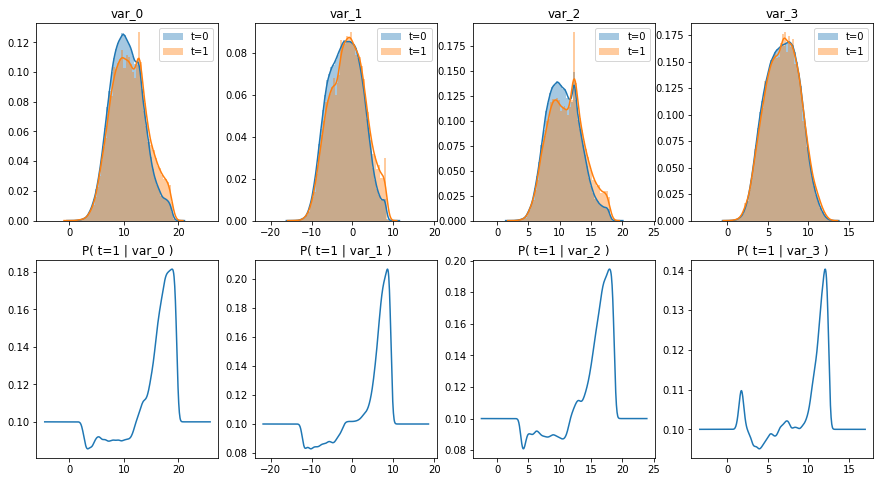

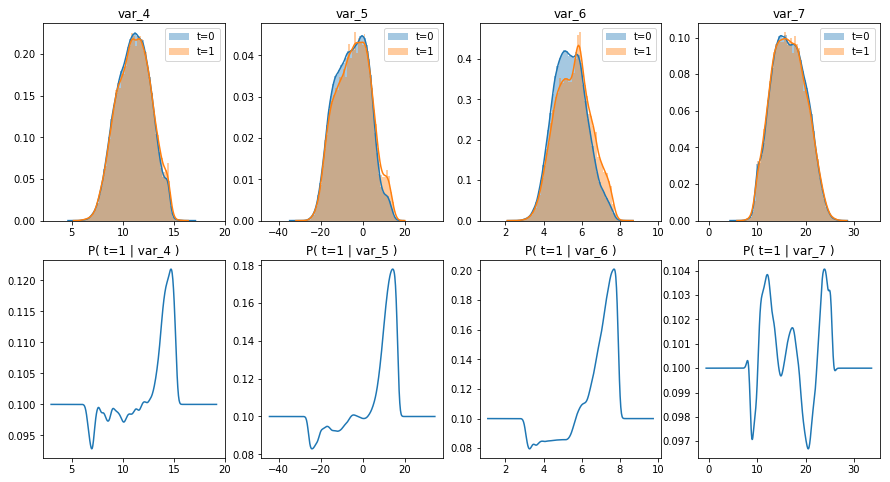

Showing vars 8 to 15 ...


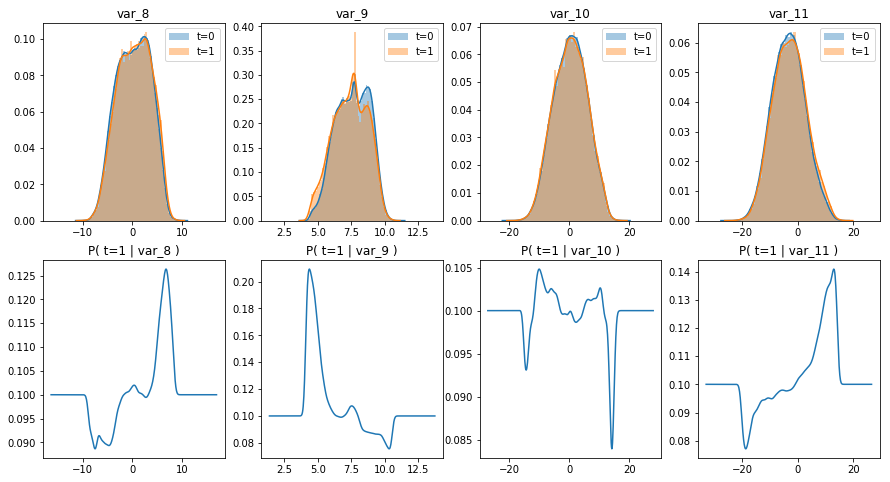

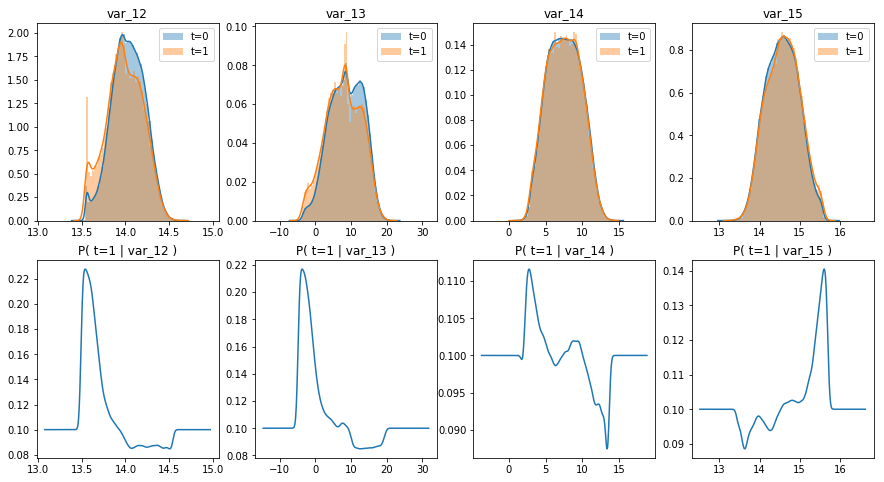

Showing vars 16 to 23 ...


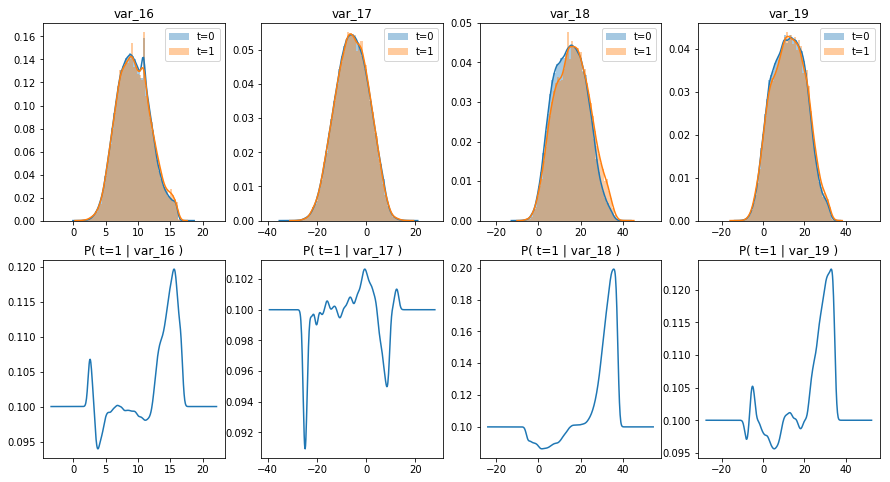

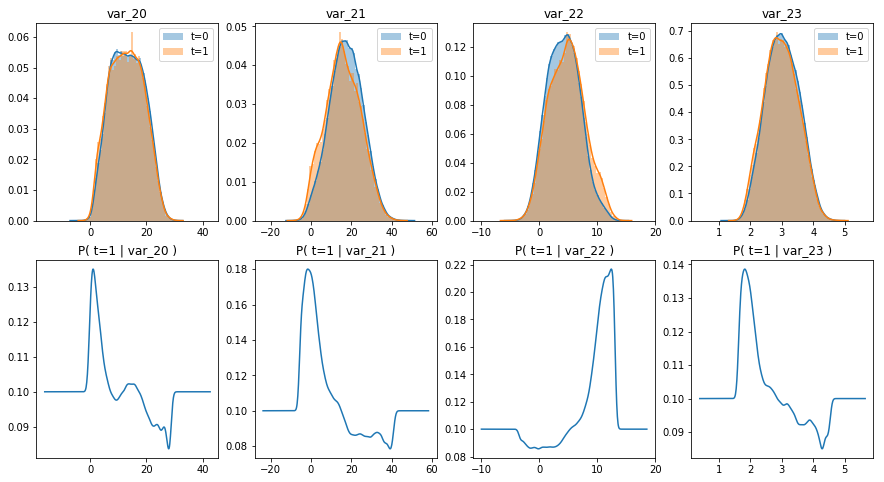

Showing vars 24 to 31 ...


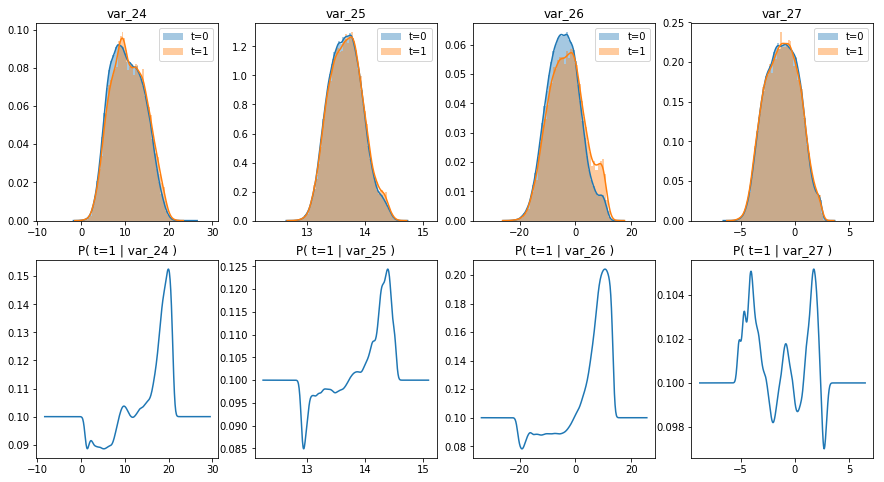

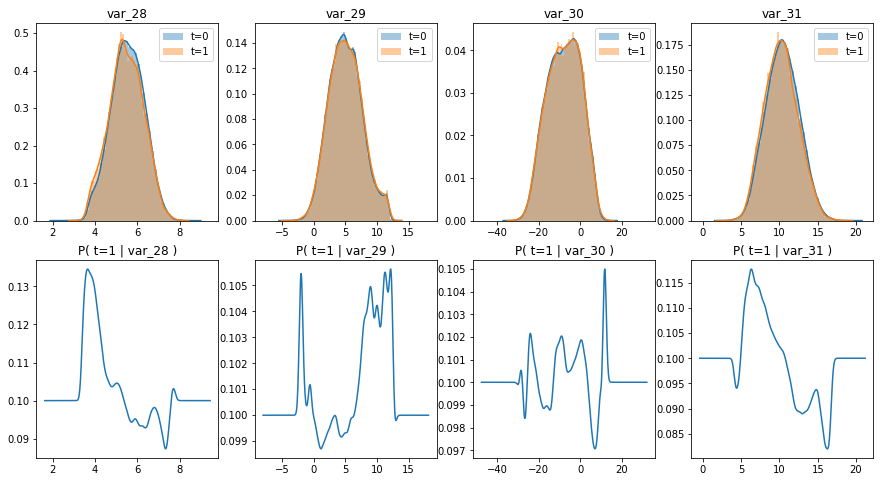

Showing vars 32 to 39 ...


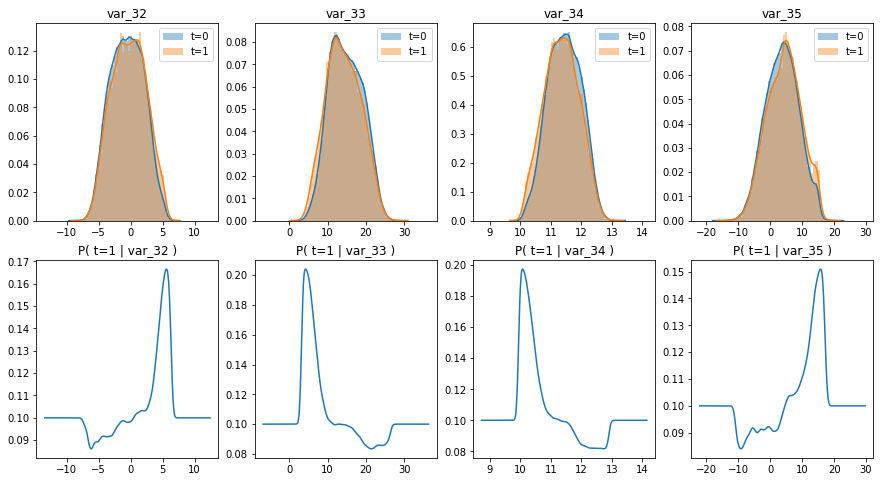

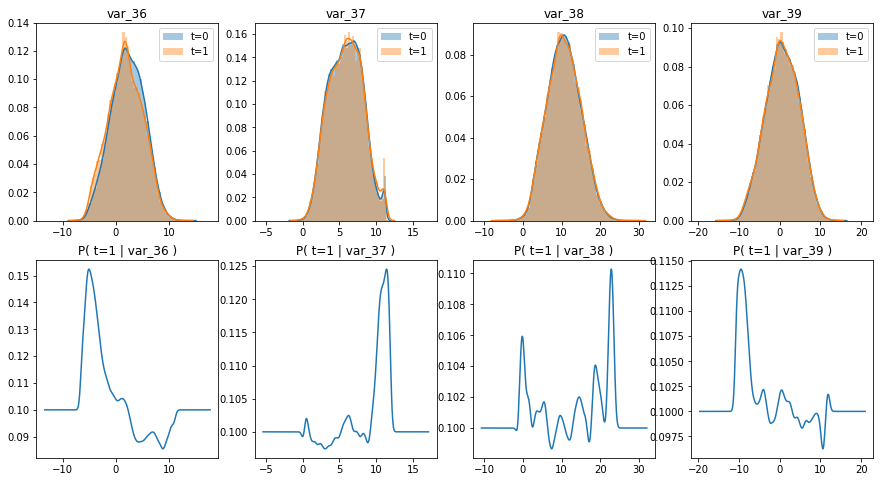

Showing vars 40 to 47 ...


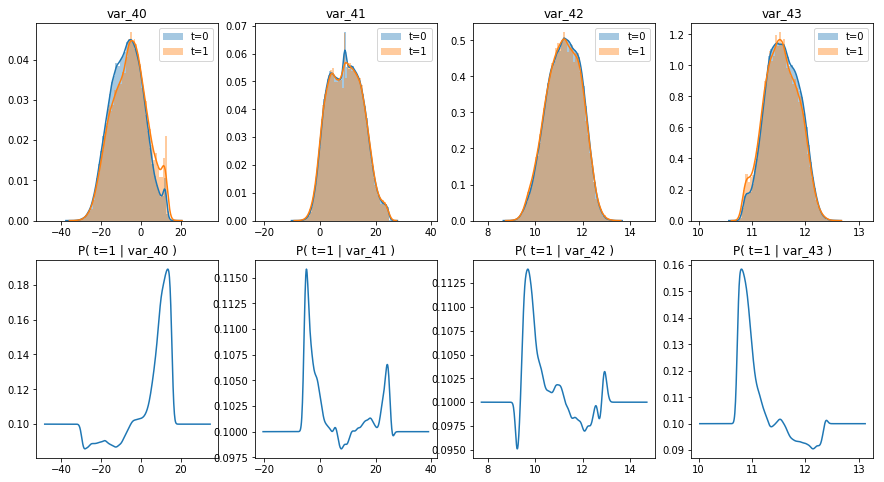

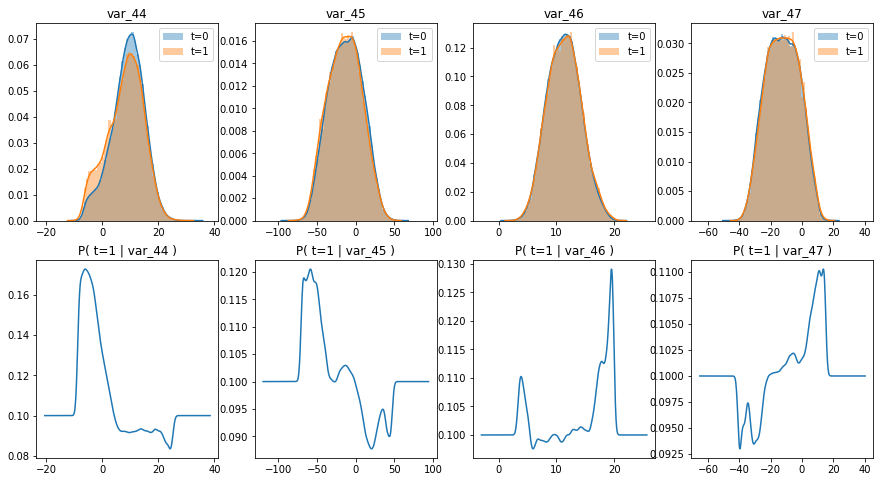

Showing vars 48 to 55 ...


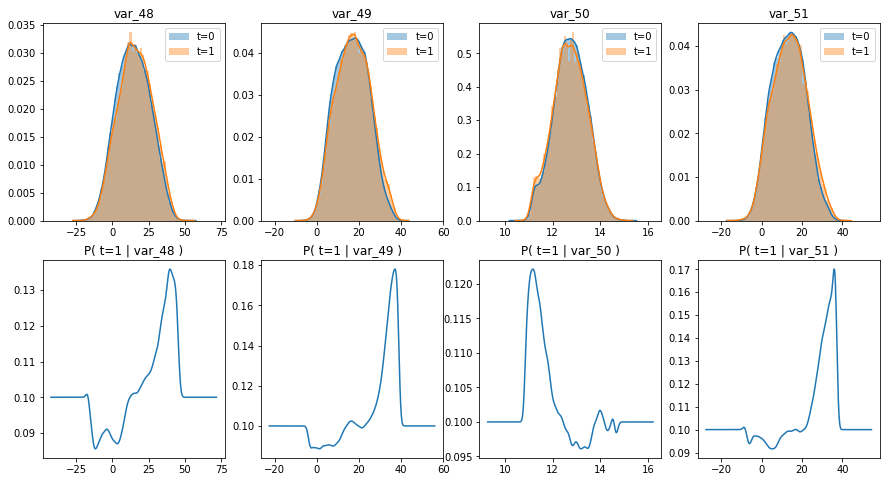

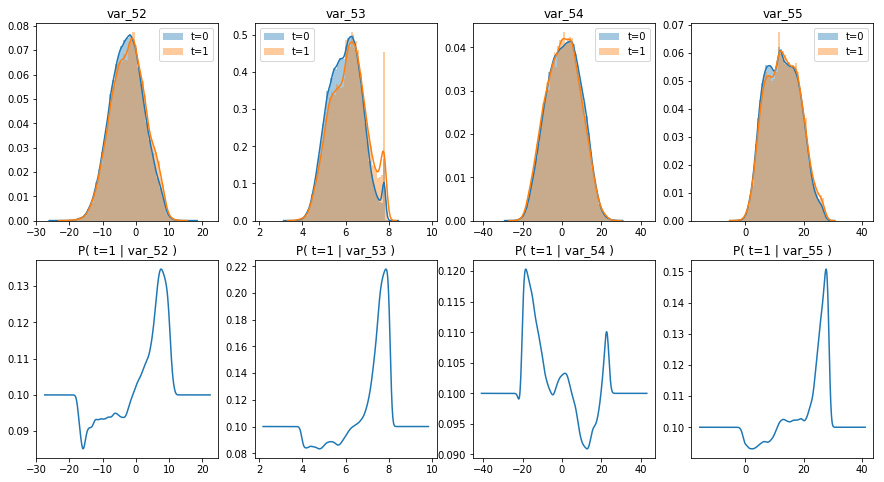

Showing vars 56 to 63 ...


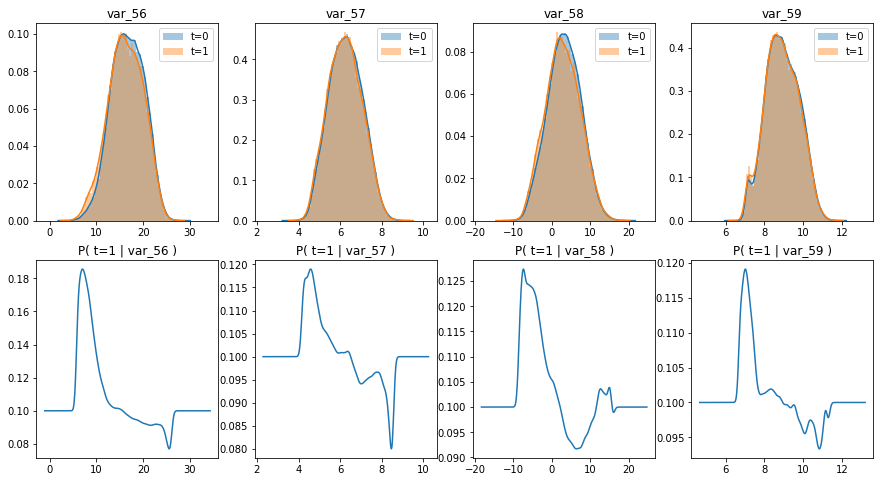

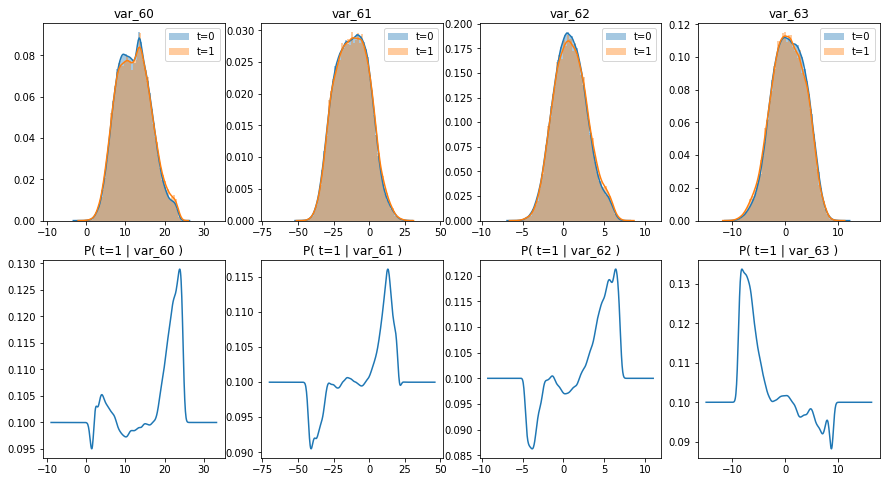

Showing vars 64 to 71 ...


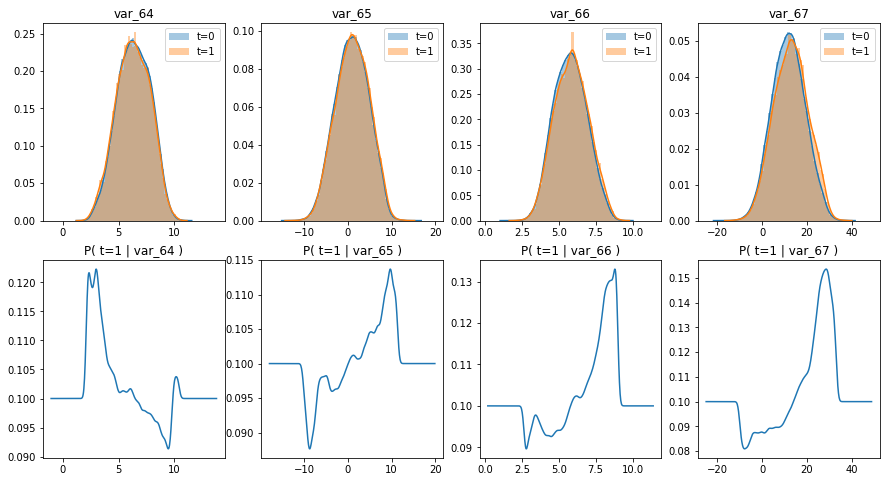

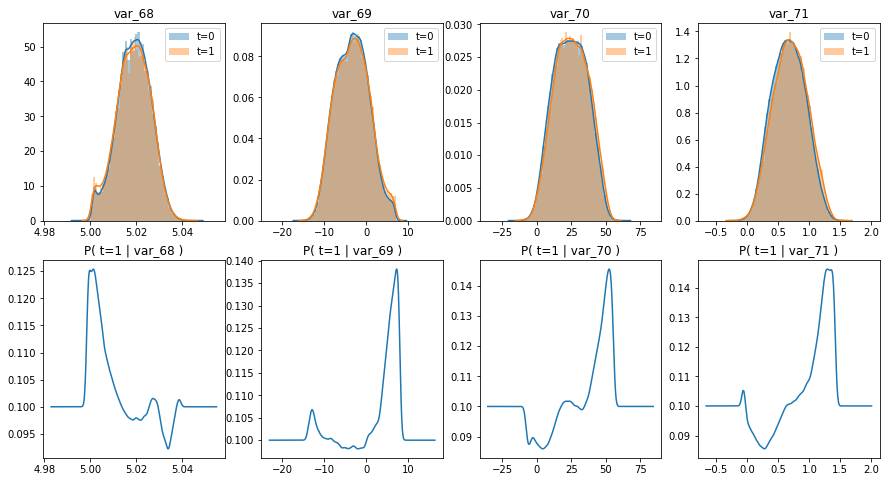

Showing vars 72 to 79 ...


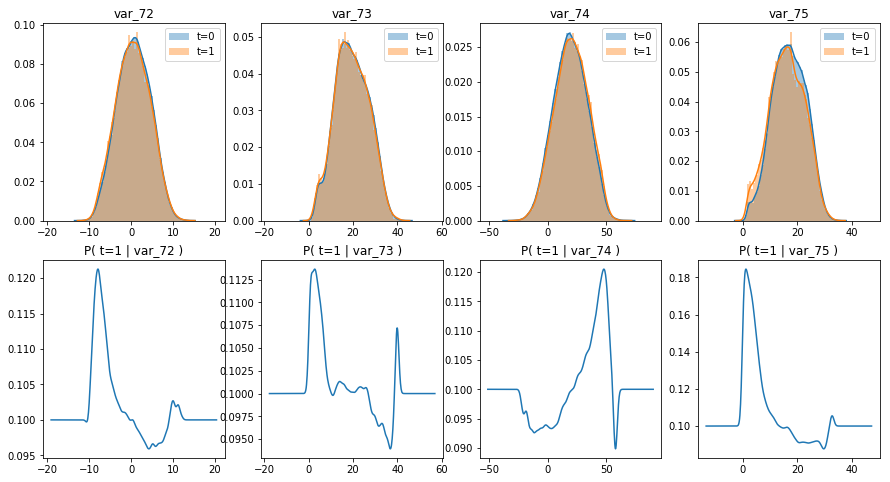

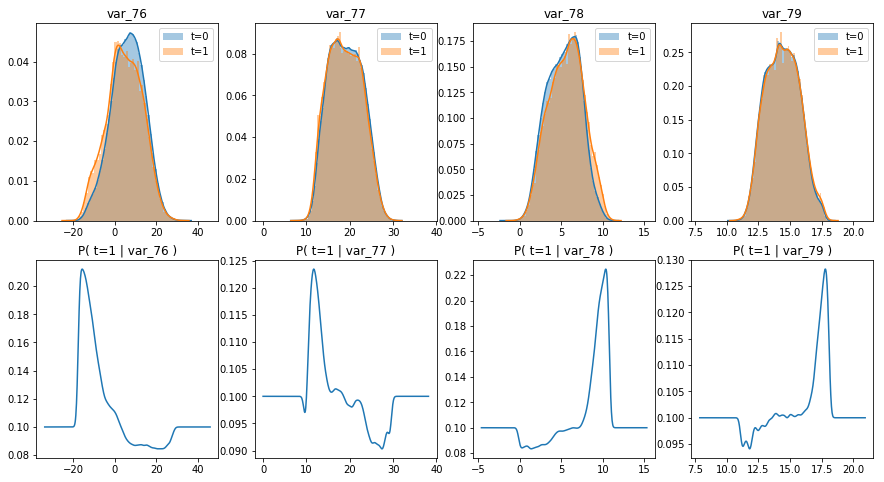

Showing vars 80 to 87 ...


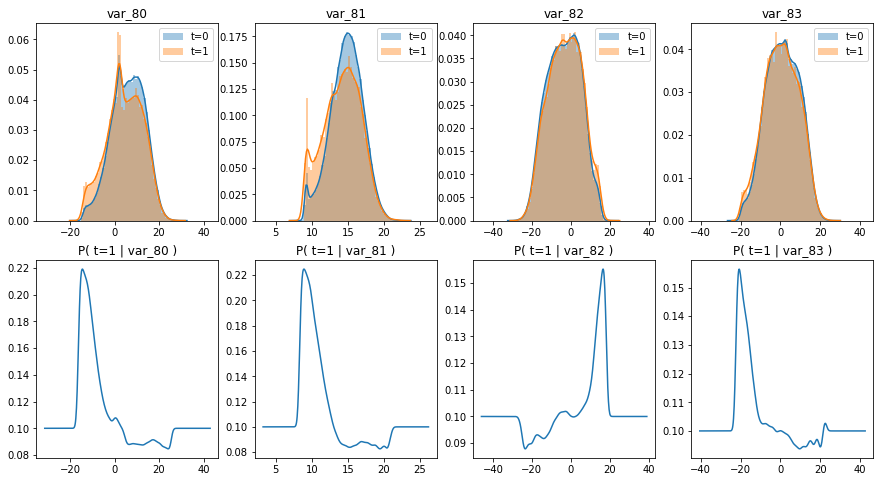

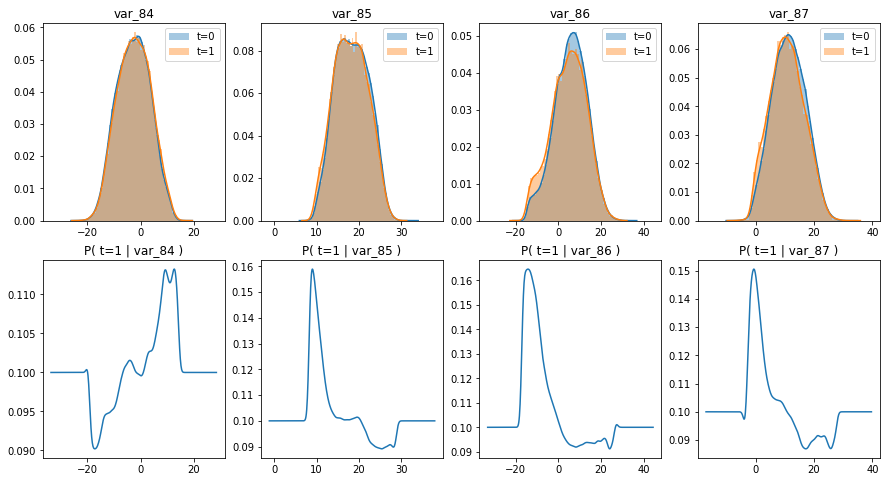

Showing vars 88 to 95 ...


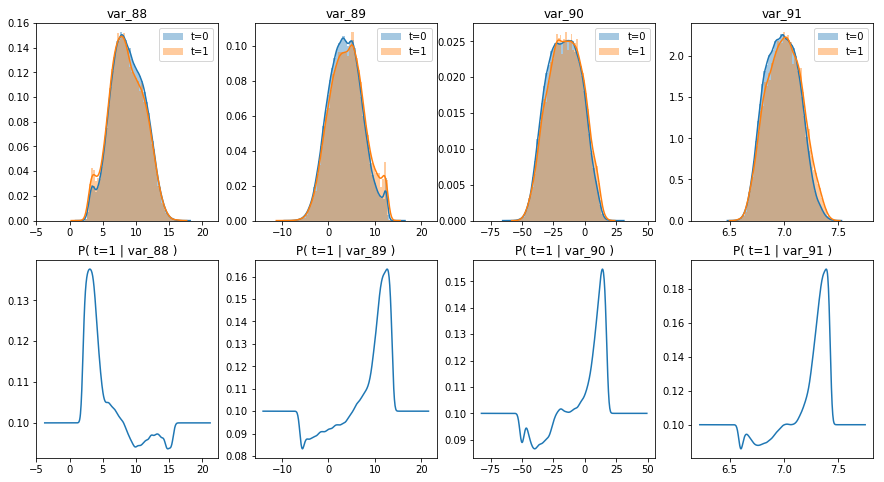

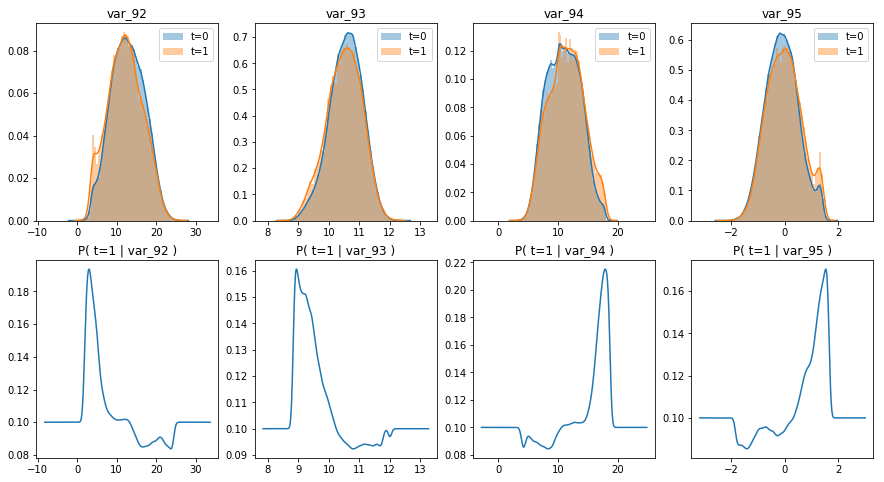

Showing vars 96 to 103 ...


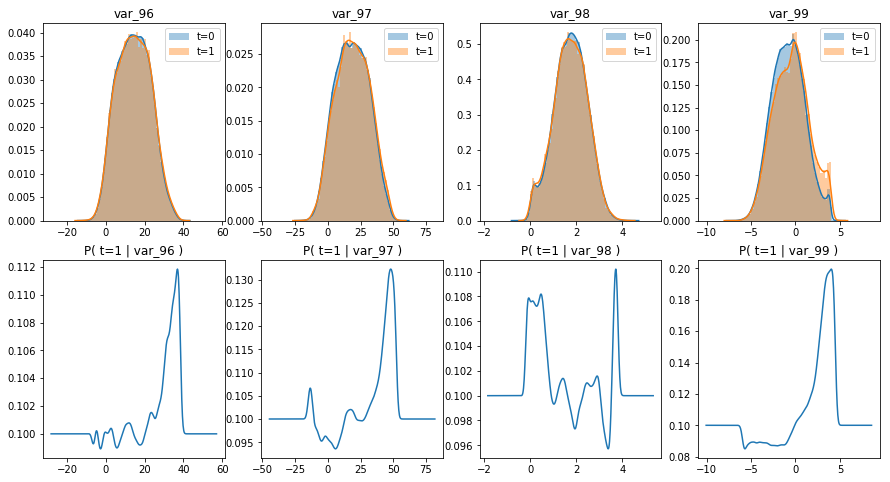

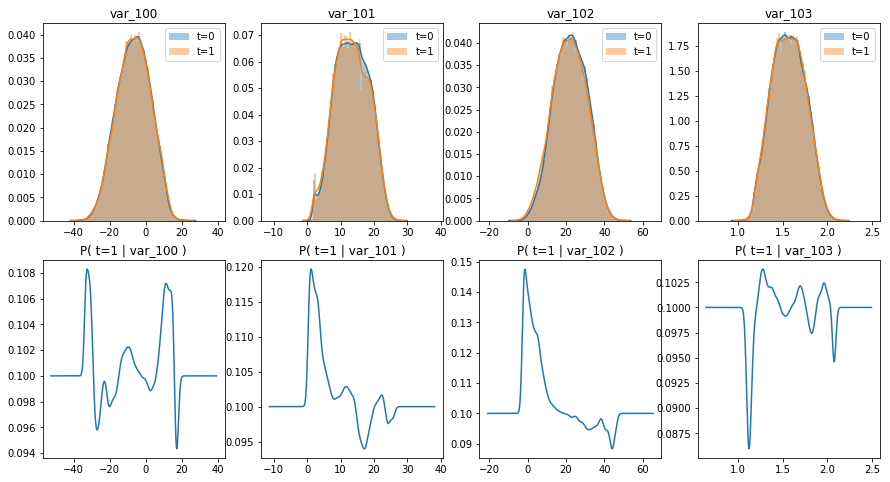

Showing vars 104 to 111 ...


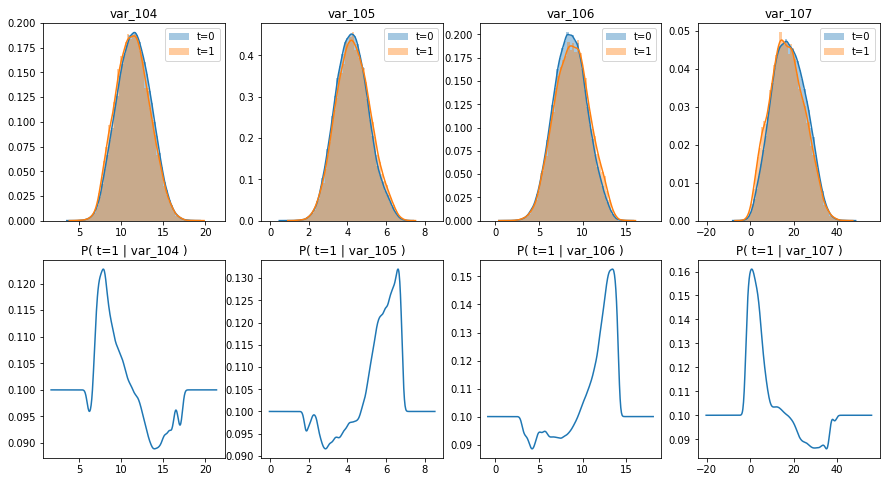

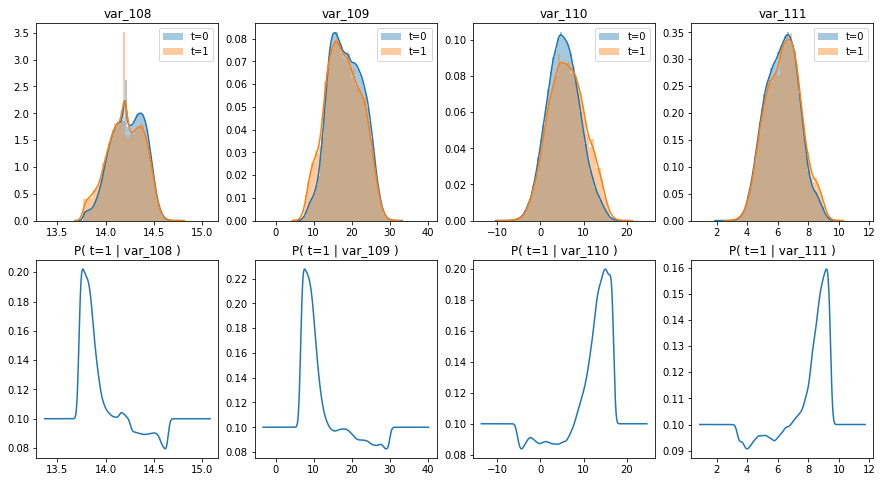

Showing vars 112 to 119 ...


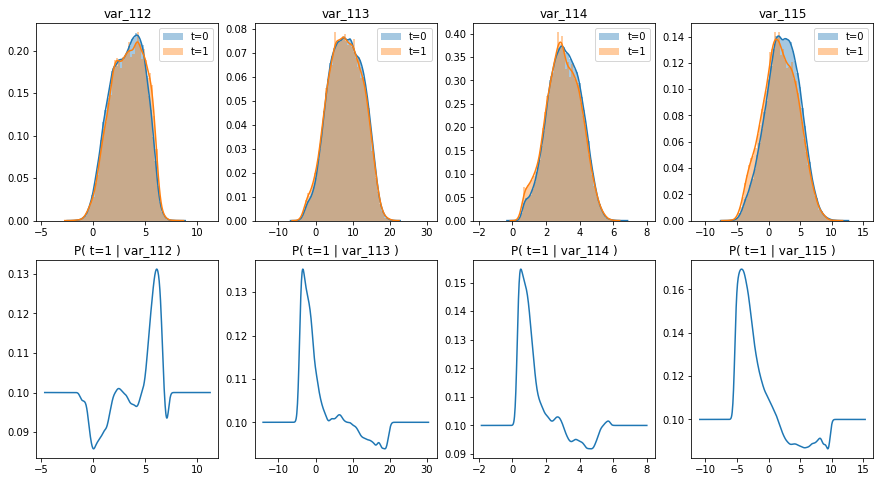

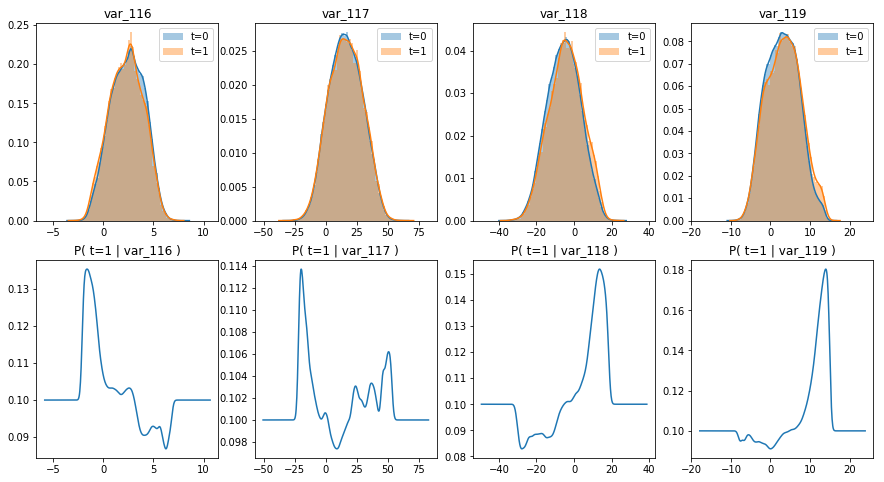

Showing vars 120 to 127 ...


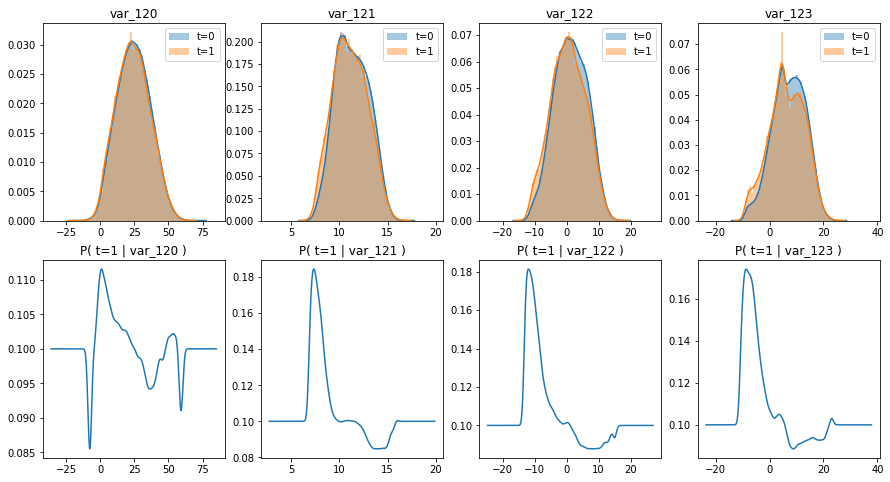

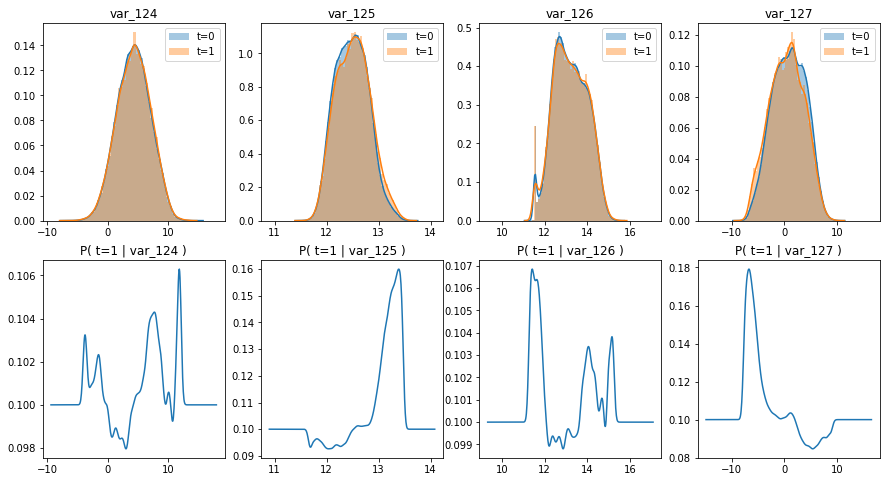

Showing vars 128 to 135 ...


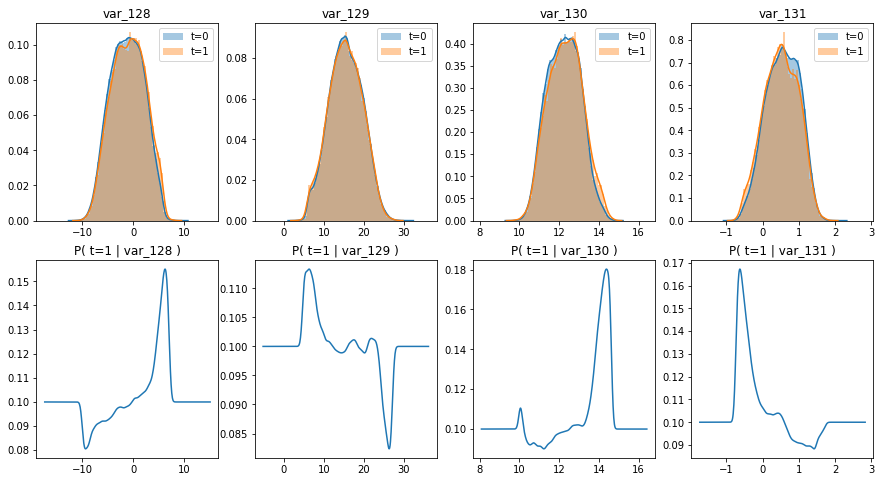

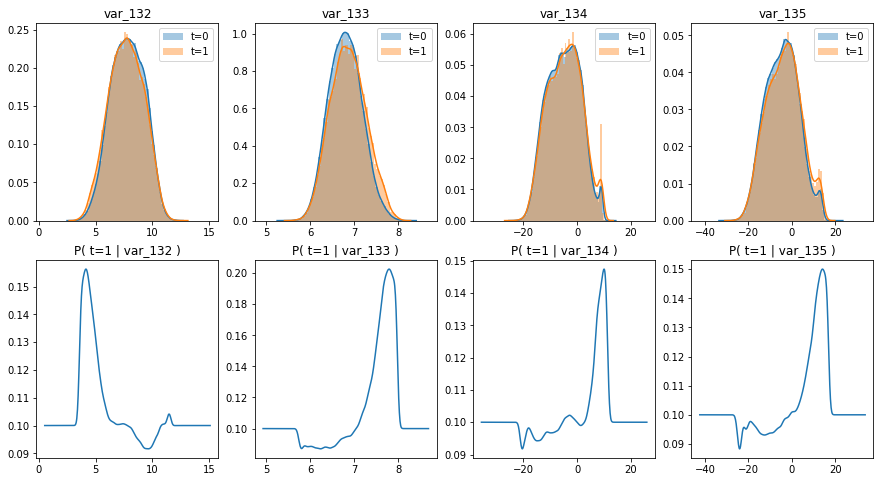

Showing vars 136 to 143 ...


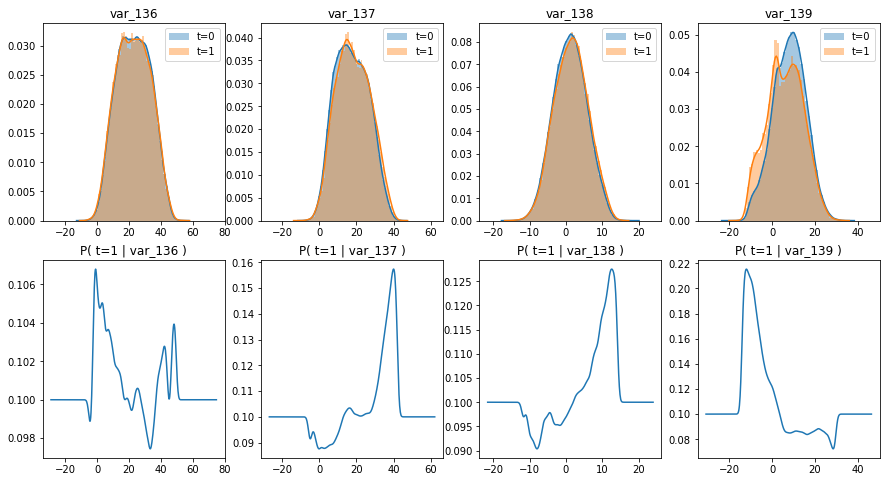

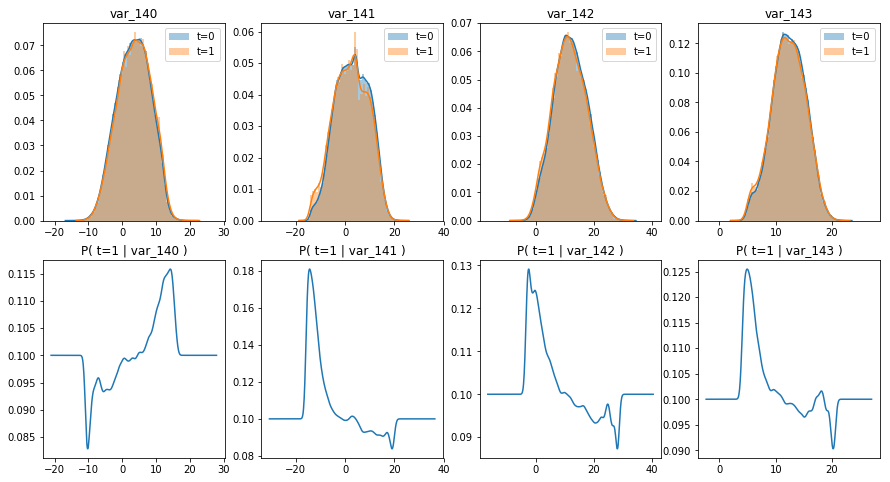

Showing vars 144 to 151 ...


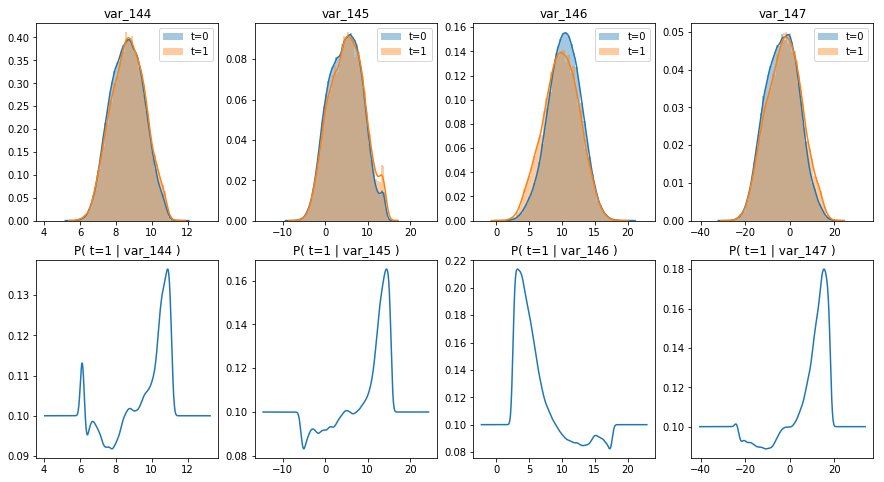

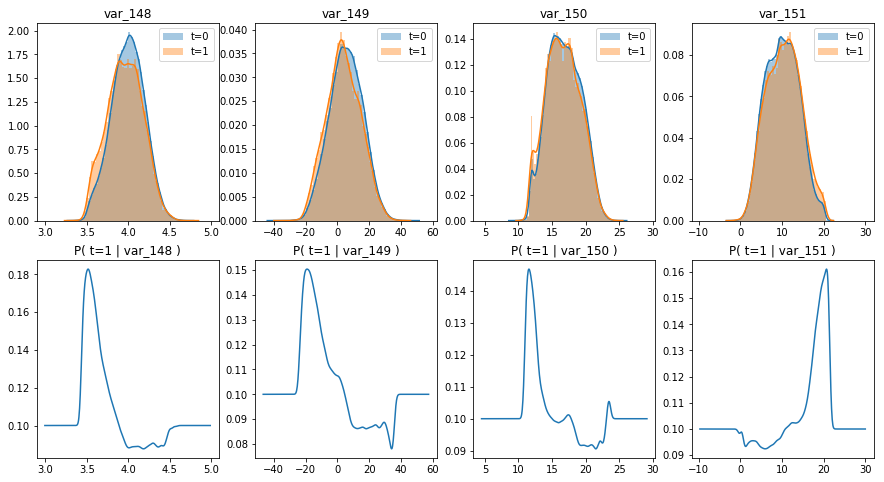

Showing vars 152 to 159 ...


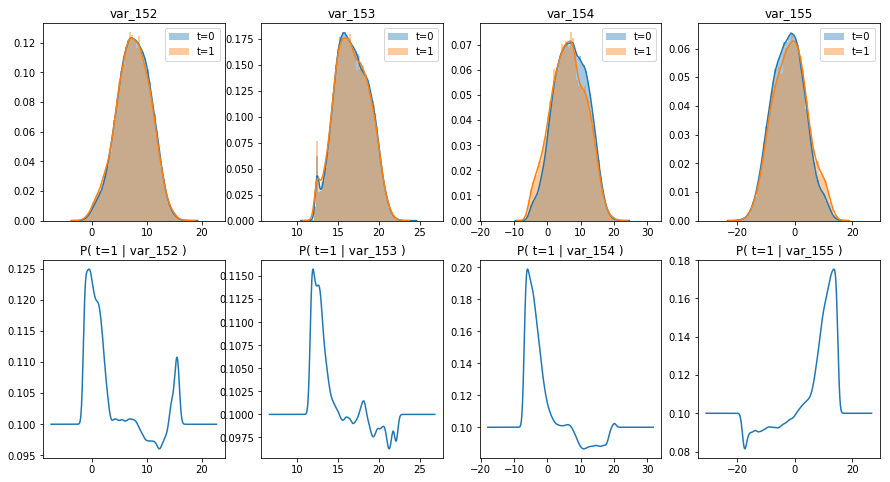

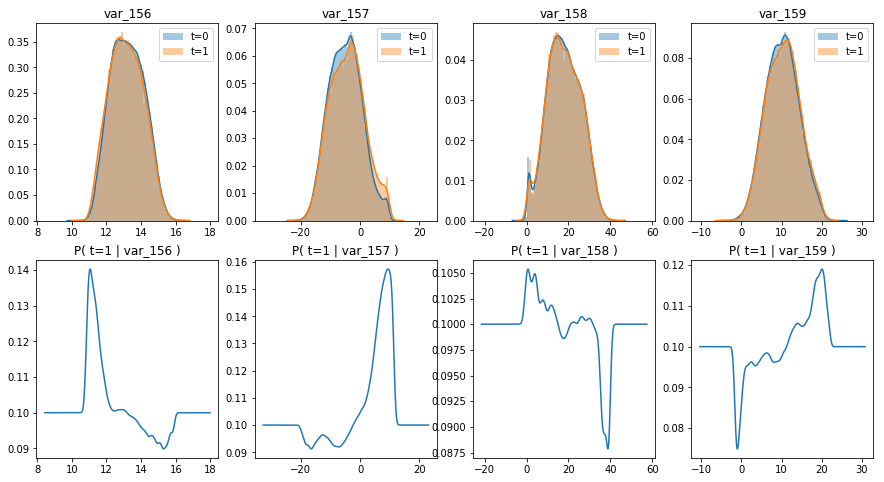

Showing vars 160 to 167 ...


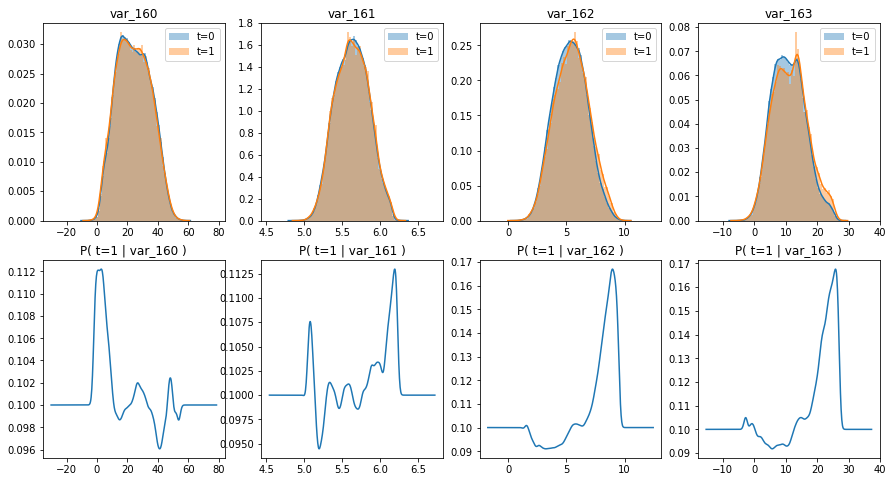

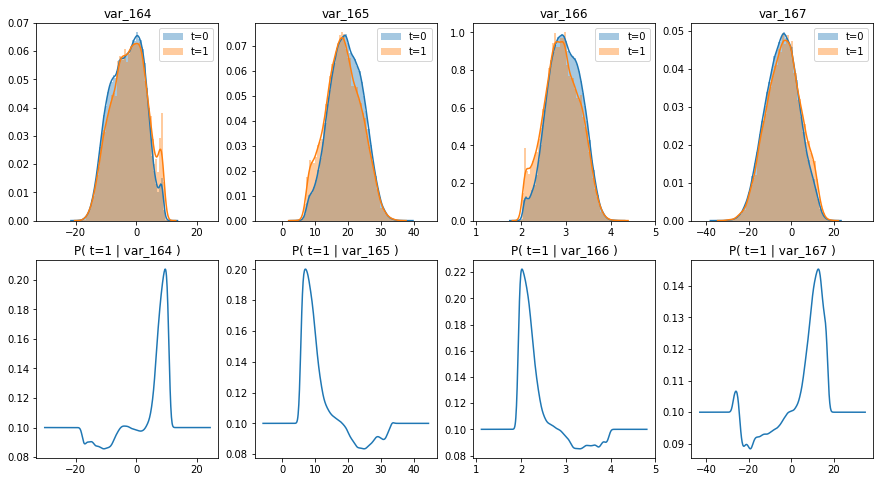

Showing vars 168 to 175 ...


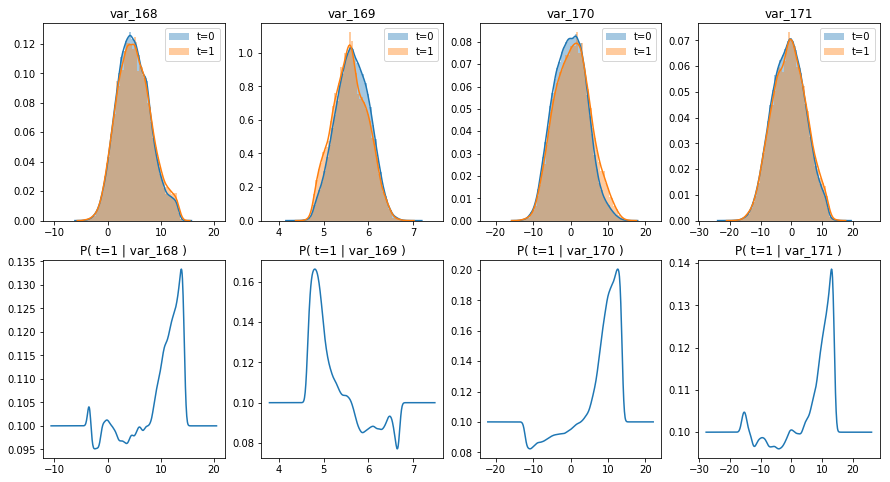

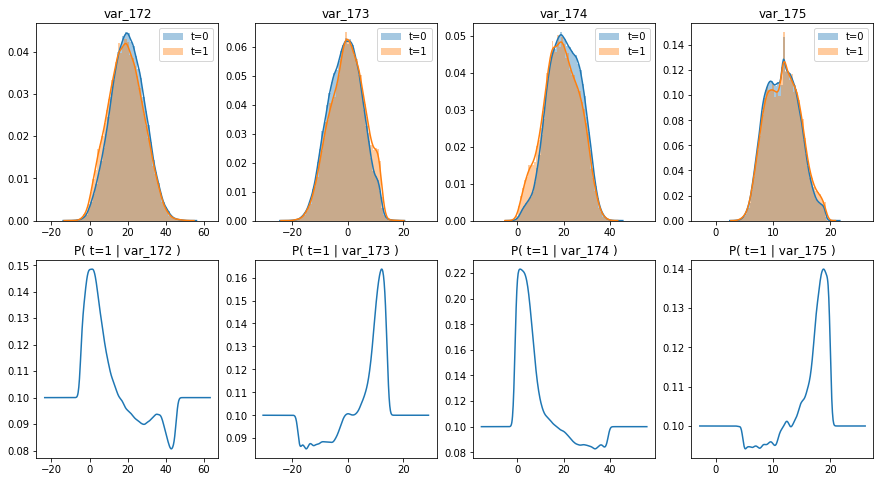

Showing vars 176 to 183 ...


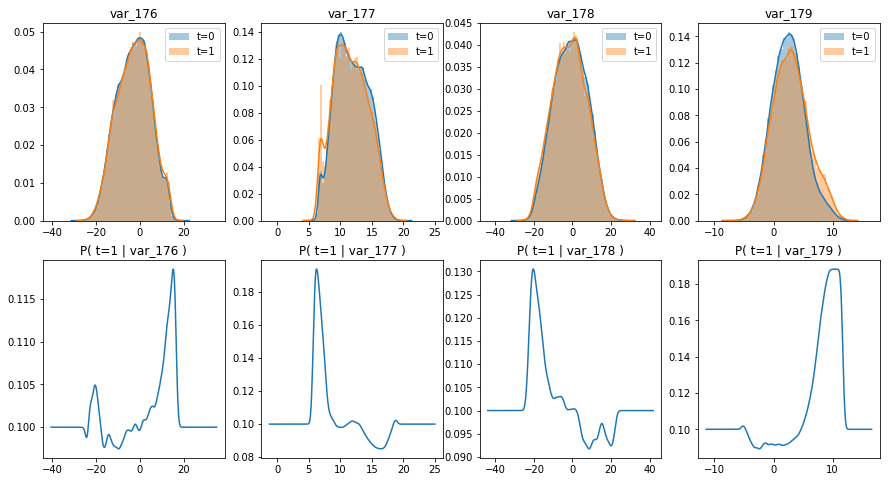

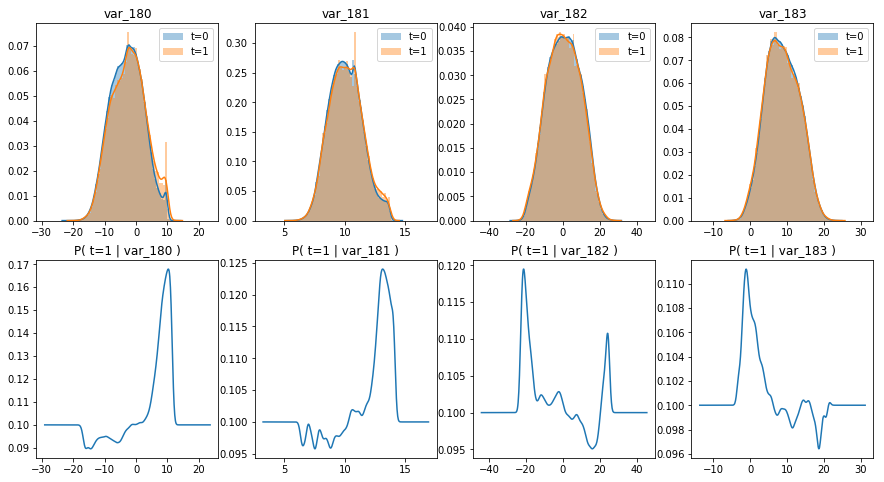

Showing vars 184 to 191 ...


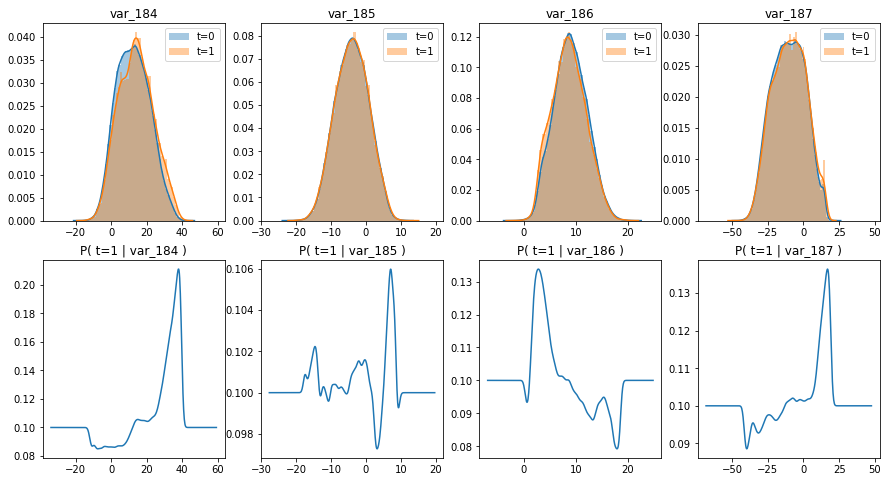

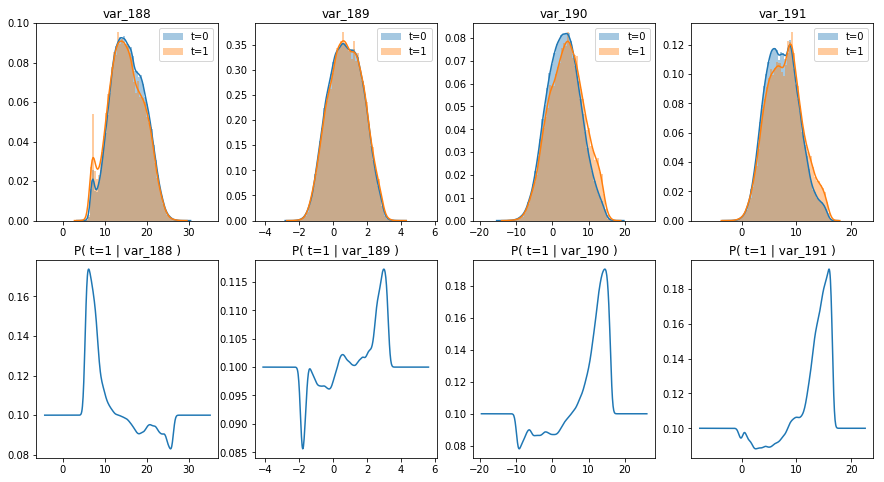

Showing vars 192 to 199 ...


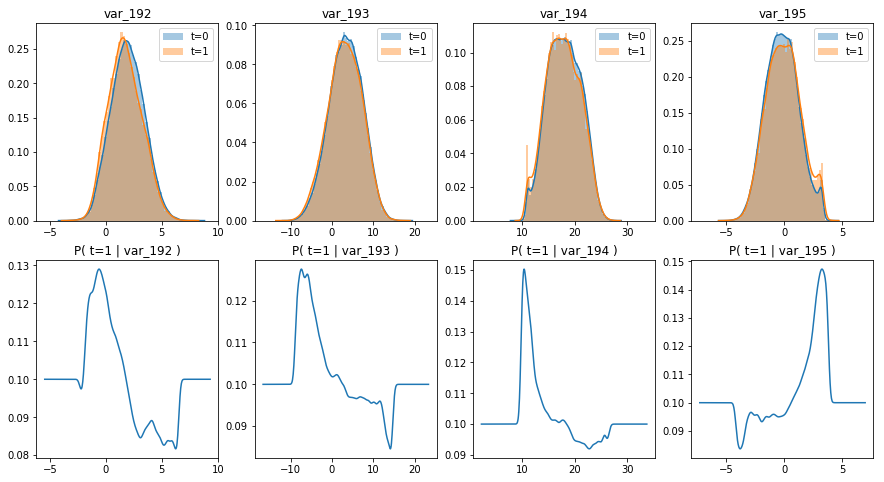

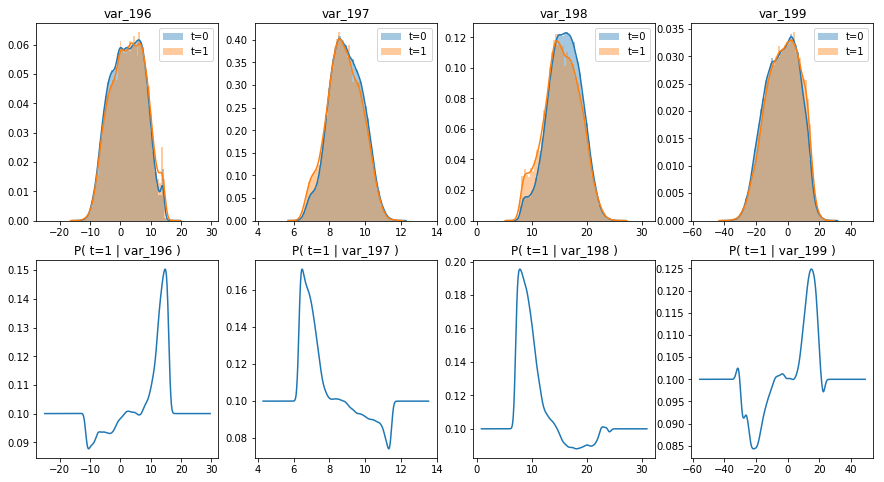

In [10]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# DRAW PLOTS, YES OR NO
Picture = False
# DATA HAS Z-SCORE RANGE OF -4.5 TO 4.5
rmin=-5; rmax=5; 
# CALCULATE PROBABILITIES FOR 501 BINS
res=501
# STORE PROBABILITIES IN PR
pr = 0.1 * np.ones((200,res))
pr2 = pr.copy()
xr = np.zeros((200,res))
xr2 = xr.copy()
ct2 = 0
for j in range(50):
    for v in range(4):
        ct = 0
        # CALCULATE PROBABILITY FUNCTION FOR VAR
        for i in np.linspace(rmin,rmax,res):
            pr[v+4*j,ct] = getp(v+4*j,m[v+4*j]+i*s[v+4*j])
            xr[v+4*j,ct] = m[v+4*j]+i*s[v+4*j]
            xr2[v+4*j,ct] = i
            ct += 1

In [36]:
splits = list(StratifiedKFold(n_splits=5, shuffle=True,random_state=1111).split(X, y))

In [9]:
rmin=-5; rmax=5; 
res=501
nb_oof=np.zeros(len(X)) 
nb_pred=np.zeros(len(X_test))
for fold, (train_idx, valid_idx) in enumerate(splits):
    print (fold)
    train_t=np.array(train)
    x_train=train_t[train_idx]
    x_train= pd.DataFrame(x_train, columns=train.columns)
    
    train0 = x_train[x_train['target']==0].copy()
    train1 = x_train[x_train['target']==1].copy()
    break

0


In [13]:
rmin=-5; rmax=5; 
res=501
nb_oof=np.zeros(len(X)) 
nb_pred=np.zeros(len(X_test))
for fold, (train_idx, valid_idx) in enumerate(splits):
    print (fold)
    train_t=np.array(train)
    x_train=train_t[train_idx]
    x_train= pd.DataFrame(x_train, columns=train.columns)
    
    train0 = x_train[x_train['target']==0].copy()
    train1 = x_train[x_train['target']==1].copy()
    
    s = [0]*200
    m = [0]*200
    for i in range(200):
        s[i] = np.std(x_train["var_"+str(i)])
        m[i] = np.mean(x_train["var_"+str(i)])
    print ('std and mean calculated for subset ')    
    pr = 0.1 * np.ones((200,res))
    pr2 = pr.copy()
    xr = np.zeros((200,res))
    xr2 = xr.copy()
    ct2 = 0
    for j in range(50):
        for v in range(4):
            ct = 0
        # CALCULATE PROBABILITY FUNCTION FOR VAR
            for i in np.linspace(rmin,rmax,res):
                pr[v+4*j,ct] = getp(v+4*j,m[v+4*j]+i*s[v+4*j])
                xr[v+4*j,ct] = m[v+4*j]+i*s[v+4*j]
                xr2[v+4*j,ct] = i
                ct += 1
    print ('probability done for subset ')
    for r in valid_idx:
        p = 0.1
        for i in range(200):
            p *= 10*getp2(i,train.iloc[r,2+i])
        nb_oof[r]=p
    print ('oof done for subset ')
    ct = 0
    for r in test.index:
        p = 0.1
        for i in range(200):
            p *= 10*getp2(i,test.iloc[r,1+i])
        nb_pred[ct]+=p/5
        ct += 1
    print ('prediction done for subset ')
    #break    
print('###############')
print('Validation AUC =',roc_auc_score(train['target'], nb_oof))

0
std and mean calculated for subset 
probability done for subset 
oof done for subset 
prediction done for subset 
1
std and mean calculated for subset 
probability done for subset 
oof done for subset 
prediction done for subset 
2
std and mean calculated for subset 
probability done for subset 
oof done for subset 
prediction done for subset 
3
std and mean calculated for subset 
probability done for subset 
oof done for subset 
prediction done for subset 
4
std and mean calculated for subset 
probability done for subset 
oof done for subset 
prediction done for subset 
###############
Validation AUC = 0.8994647655377712


In [16]:
#blend_train=pd.read_csv("data/oof_train.csv")
blend_train['nb']=nb_oof

In [17]:
blend_train.describe()

lgb            xgb             et             rf  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.122426       0.031736       0.141378       0.462142   
std         0.184817       0.095804       0.014480       0.029265   
min         0.000081       0.000011       0.093032       0.362467   
25%         0.016470       0.001674       0.131309       0.441959   
50%         0.046171       0.004947       0.140074       0.460285   
75%         0.135814       0.016842       0.149925       0.480155   
max         0.999214       0.998312       0.235257       0.601022   

                  nb  
count  200000.000000  
mean        0.532505  
std         6.822721  
min         0.000252  
25%         0.020133  
50%         0.054885  
75%         0.170041  
max      1309.814299

In [26]:
#blend_test=pd.read_csv("data/test_pred_layer_1.csv")
blend_test.describe()

lgb            xgb             et             rf  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.115152       0.031305       0.141387       0.462227   
std         0.164962       0.092649       0.013492       0.027314   
min         0.000107       0.000017       0.092282       0.351221   
25%         0.018151       0.002217       0.132016       0.443465   
50%         0.049275       0.006380       0.140487       0.461118   
75%         0.135203       0.020196       0.149694       0.479714   
max         0.998553       1.197919       0.221672       0.598871   

                  nb  
count  200000.000000  
mean        0.371291  
std         4.218662  
min         0.000192  
25%         0.021935  
50%         0.058387  
75%         0.168124  
max       853.745483

In [25]:
#blend_test=blend_test.drop('Unnamed: 0', axis=1)
blend_test["nb"]=nb_pred

In [22]:
blend_train['lgb_rank']=blend_train['lgb'].rank(ascending=True)
blend_train['xgb_rank']=blend_train['xgb'].rank(ascending=True)
blend_train['et_rank']=blend_train['et'].rank(ascending=True)
blend_train['rf_rank']=blend_train['rf'].rank(ascending=True)
blend_train['nb_rank']=blend_train['nb'].rank(ascending=True)

In [32]:
blend_train['lgb_pred']=blend_train['lgb_rank']/200000
blend_train['xgb_pred']=blend_train['xgb_rank']/200000
blend_train['et_pred']=blend_train['et_rank']/200000
blend_train['rf_pred']=blend_train['rf_rank']/200000
blend_train['nb_pred']=blend_train['nb_rank']/200000

In [11]:
oof = np.zeros(len(X))
predictions = np.zeros(len(X_test))
feature_importance_df_1 = pd.DataFrame()

for i, (train_idx, valid_idx) in enumerate(splits):  
    print(f'Fold {i + 1}')
    x_train = np.array(X)
    y_train = np.array(y)
    trn_data = lgb.Dataset(x_train[train_idx.astype(int)], label=y_train[train_idx.astype(int)])
    val_data = lgb.Dataset(x_train[valid_idx.astype(int)], label=y_train[valid_idx.astype(int)])
    
    num_round = 15000
    clf_1 = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[valid_idx] = clf_1.predict(x_train[valid_idx], num_iteration=clf_1.best_iteration)
    
    fold_importance_df_1 = pd.DataFrame()
    fold_importance_df_1["feature"] = features
    fold_importance_df_1["importance"] = clf_1.feature_importance()
    fold_importance_df_1["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df_1, fold_importance_df_1], axis=0)
    
    predictions += clf_1.predict(X_test, num_iteration=clf_1.best_iteration) / 5

print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))

Fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.884517	valid_1's auc: 0.873736
[2000]	training's auc: 0.896044	valid_1's auc: 0.883841
[3000]	training's auc: 0.903873	valid_1's auc: 0.889122
[4000]	training's auc: 0.909983	valid_1's auc: 0.892969
[5000]	training's auc: 0.914635	valid_1's auc: 0.895644
[6000]	training's auc: 0.918531	valid_1's auc: 0.897668
[7000]	training's auc: 0.921768	valid_1's auc: 0.899102
[8000]	training's auc: 0.924563	valid_1's auc: 0.900202
[9000]	training's auc: 0.927146	valid_1's auc: 0.900892
[10000]	training's auc: 0.929574	valid_1's auc: 0.901417
[11000]	training's auc: 0.932027	valid_1's auc: 0.901742
Early stopping, best iteration is:
[11870]	training's auc: 0.934106	valid_1's auc: 0.90193
Fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.885244	valid_1's auc: 0.871814
[2000]	training's auc: 0.89668	valid_1's auc: 0.880216
[3000]	training's auc: 0.904523	valid_1'

In [54]:
oof = np.zeros(len(X))
predictions = np.zeros(len(X_test))
feature_importance_df_1 = pd.DataFrame()

for i, (train_idx, valid_idx) in enumerate(splits):  
    print(f'Fold {i + 1}')
    x_train = np.array(X)
    y_train = np.array(y)
    trn_data = lgb.Dataset(x_train[train_idx.astype(int)], label=y_train[train_idx.astype(int)])
    val_data = lgb.Dataset(x_train[valid_idx.astype(int)], label=y_train[valid_idx.astype(int)])
    
    num_round = 15000
    clf_1 = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
    oof[valid_idx] = clf_1.predict(x_train[valid_idx], num_iteration=clf_1.best_iteration)
    
    fold_importance_df_1 = pd.DataFrame()
    fold_importance_df_1["feature"] = features
    fold_importance_df_1["importance"] = clf_1.feature_importance()
    fold_importance_df_1["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df_1, fold_importance_df_1], axis=0)
    
    predictions += clf_1.predict(X_test, num_iteration=clf_1.best_iteration) / 5

print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))

Fold 1
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.876313	valid_1's auc: 0.86417
[2000]	training's auc: 0.902366	valid_1's auc: 0.884203
[3000]	training's auc: 0.914893	valid_1's auc: 0.892655
[4000]	training's auc: 0.922801	valid_1's auc: 0.897459
[5000]	training's auc: 0.92847	valid_1's auc: 0.900168
[6000]	training's auc: 0.933042	valid_1's auc: 0.901778
[7000]	training's auc: 0.937336	valid_1's auc: 0.902652
[8000]	training's auc: 0.941543	valid_1's auc: 0.903181
[9000]	training's auc: 0.945712	valid_1's auc: 0.903521
Early stopping, best iteration is:
[8908]	training's auc: 0.94532	valid_1's auc: 0.903545
Fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.877118	valid_1's auc: 0.855764
[2000]	training's auc: 0.903514	valid_1's auc: 0.87706
[3000]	training's auc: 0.916379	valid_1's auc: 0.885719
[4000]	training's auc: 0.924361	valid_1's auc: 0.890288
[5000]	training's auc: 0.92994	valid_1's auc:

## Stacking

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
estimators=[lgb.clf, xgb.clf, nn.clf]

In [ ]:
X_train_predictions = np.empty((len(X_train), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_train_predictions[:, index] = estimator.predict(X_train)

### A random forest blender

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_train_predictions, y_train)

In [ ]:
rnd_forest_blender.oob_score_

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
y_pred = rnd_forest_blender.predict(X_val_predictions)

### Alternatively, a logistic regression blender

In [ ]:
logistic_blender=LogisticRegression()
logistic_blender.fit(X_train_predictions, y_train)

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
y_pred = logistic_blender.predict(X_val_predictions)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred)

In [ ]:
def accuracies(model,valid_data,valid_label):
    pred=model.predict(valid_data)
    print accuracy_score(pred, valid_label)

for model in estimators:
    accuracies(model, X_val, y_val)    

In [ ]:
from sklearn.model_selection import cross_val_score

(cross_val_score(lasso, X, y, cv=3)) 